Here is the XGBoost model. Importantly the same manner of mixed scaling, as the second LSTM model, is employeed: StandardScaler is used for the training set, and the forcasting is anchored to the rolling mean and std.

The MAPE is close to the persistence model, thanks to the same reason.

XGBoost is faster (for training) than LSTM, and is easy to include extra features. 

In [1]:
import numpy as np
import math

import pandas as pd
#import pandas_datareader as pdr

from datetime import datetime as dt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from matplotlib import pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# common setting for all models
ticker = 'FSLR'
splitting = 0.2,0.2 # for valication, testing, and the rest for training
metrics = pd.DataFrame()

def forecast_metrics(y_true, y_pred, algo='Algo'):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = 100 * np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # MAPE
    smape = 200 * np.mean((np.abs(y_pred - y_true)
                    / (np.abs(y_pred) + np.abs(y_true))))
    corr = np.corrcoef(y_pred, y_true)[0,1]   # corr
    mins = np.amin(np.hstack([y_pred[:,None], 
                              y_true[:,None]]), axis=1)
    maxs = np.amax(np.hstack([y_pred[:,None], 
                              y_true[:,None]]), axis=1)
    minmax = 100*(1 - np.mean(mins/maxs))             # minmax
    return pd.DataFrame({'RMSE': rmse,
                         'MAPE': mape,
                         'SMAPE': smape,
                         'MinMax': minmax,
                         'Corr': corr
                        }, index=[algo]
          )

data = pd.read_csv('data/{0}.csv'.format(ticker.lower()), parse_dates=['date'])
data.sort_values(by='date', inplace=True, ascending=True) # not needed, but to make sure

ndata = len(data)
ntest = int(ndata * splitting[-1])
nval = int(ndata * splitting[-2])
ntrain = ndata - ntest - nval
ntrval = ntrain + nval

data.head(5)

,date,high,low,open,close,volume,adj_close
0,2014-01-02,57.580002,54.009998,54.279999,57.439999,5404200,57.439999
1,2014-01-03,58.299999,55.849998,57.590000,56.740002,4118700,56.740002
2,2014-01-06,54.630001,51.009998,54.250000,51.259998,11791700,51.259998
3,2014-01-07,53.889999,52.060001,52.150002,52.490002,6661900,52.490002
4,2014-01-08,52.889999,51.410000,52.290001,51.680000,4930200,51.680000


### Modelling

In [3]:
# initial/dryrun parameters
N = 15 # from LSTM
seed = 42

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 0.8                # Subsample ratio of the training instance. default = 1
colsample_bytree = 0.8         # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

In [4]:
# functions to wrap lines

def get_mov_avg_std(df, col, N):

    df_out = df.copy()
    df_out[col + '_mean'] = df[col].rolling(window = N, min_periods=1).mean().shift()
    df_out[col + '_std'] = df[col].rolling(window = N, min_periods=1).std().shift()
    
    return df_out


def scale_row(row, feat_mean, feat_std):

    feat_std = 0.001 if feat_std == 0 else feat_std    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled


def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=42, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0,
                          name='xgb'):

    model = XGBRegressor(objective='reg:squarederror', # silent=True
                         random_state=seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = y_pred_scaled * col_std + col_mean

    m = forecast_metrics(y_test, y_pred, name)
    
    return m, y_pred

#metrics[[param_label, param2_label]] = pd.DataFrame(metrics.index.to_list()).values
def plot_two_params_tuning(metrics, param_label, param2_label):
    temp= pd.DataFrame(metrics.index.to_list()).values
    metrics[param_label] = temp[:,0]
    metrics[param2_label] = temp[:,1]

    color_list = [
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2',  # raspberry yogurt pink
        '#7f7f7f',  # middle gray
        '#bcbd22',  # curry yellow-green
        '#17becf'   # blue-teal
    ]

    legend_list = []

    fig,ax=plt.subplots(1,1,figsize=(10,6))
    for i in range(len(param2_list)):
        temp = metrics[metrics[param2_label]==param2_list[i]]
        ax = temp.plot(x=param_label, y='MAPE', color=color_list[i%len(color_list)], marker='s', ax=ax)
        legend_list.append(f"{param2_label}_{param2_list[i]}")

    ax.set_xlabel(param_label)
    ax.set_ylabel("MAPE")
    plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
    plt.show();

In [5]:
# It is more complicated for LSTM, so I wrapped it into a function
def data_preprocessing(data_copy, N, ntrain, nval, cols_to_lag, cols_to_scale, features=()):
    """
    cols_to_lag: columns for which lags are added
    cols_to_scale: original columns for which scaling applies for the training set. In this example, cols_to_scale=['adj_close']
    features: the features which will not be scaled, like ('month', 'dayofweek')"""
    
    data = data_copy.copy()

    cols_not_scale = ['date'] + list(features)
    
    # get rolling mean and std, add lags
    for col in cols_to_lag:
        data = get_mov_avg_std(data, col, N)
        for i in range(1, N+1):
            data[f'{col}_lag_{i}'] = data[col].shift(i)
            cols_to_scale.append(f'{col}_lag_{i}')

    # Remove the first N rows which contain NaNs
    data = data[N:]
    
    # Note number of test set decreased by N here, but I prefer to keep the size of the training set
    train = data[:ntrain]
    val = data[ntrain:ntrain+nval]
    train_val = data[:ntrain+nval] # convinient
    test = data[ntrain+nval:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[cols_to_scale])

    # Convert the numpy array back into pandas dataframe
    train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
    train_scaled[cols_not_scale] = train.reset_index()[cols_not_scale]

    # Same for train+val
    scaler_train_val = StandardScaler()
    train_val_scaled = scaler_train_val.fit_transform(train_val[cols_to_scale])
    train_val_scaled = pd.DataFrame(train_val_scaled, columns=cols_to_scale)
    train_val_scaled[cols_not_scale] = train_val.reset_index()[cols_not_scale]

    # Do "local" scaling for val and test
    val_scaled = val[cols_not_scale]
    test_scaled = test[cols_not_scale]
    for col in cols_to_lag:
        feat_list = [f'{col}_lag_{i}' for i in range(1, N+1)]
        # for val
        temp = val.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
        val_scaled = pd.concat([val_scaled, temp], axis=1)
        # same for test
        temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
        test_scaled = pd.concat([test_scaled, temp], axis=1)

    # column names of the featuers (list), and target, to make all data columns consistent
    features = list(features) + cols_to_scale[1:]
    features.sort()  # xgboost depends on the order of features, when there are ties
    target = cols_to_scale[0]
    
    # Split into X and y
    X_train = train[features]
    y_train = train[target]
    X_val = val[features]
    y_val = val[target]
    X_train_val = train_val[features]
    y_train_val = train_val[target]
    X_test = test[features]
    y_test = test[target]

    X_train_scaled = train_scaled[features]
    y_train_scaled = train_scaled[target]
    X_val_scaled = val_scaled[features]
    X_train_val_scaled = train_val_scaled[features]
    y_train_val_scaled = train_val_scaled[target]
    X_test_scaled = test_scaled[features]
    
    return (scaler, scaler_train_val,
            train, val, train_val, test,
            train_scaled, val_scaled, train_val_scaled, test_scaled,
            X_train, y_train, X_val, y_val, 
            X_train_val, y_train_val, X_test, y_test, 
            X_train_scaled, y_train_scaled, X_val_scaled,
            X_train_val_scaled, y_train_val_scaled, X_test_scaled)

### Feature Engineering

* Difference between high and low of each day
* Difference between open and close of each day


In [6]:
# Get difference between high and low of each day
data['range_hl'] = data['high'] - data['low']
data.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
data['range_oc'] = data['open'] - data['close']
data.drop(['open', 'close'], axis=1, inplace=True)

data.head()

data_copy = data.copy()

,date,volume,adj_close,range_hl,range_oc
0,2014-01-02,5404200,57.439999,3.570004,-3.160000
1,2014-01-03,4118700,56.740002,2.450001,0.849998
2,2014-01-06,11791700,51.259998,3.620003,2.990002
3,2014-01-07,6661900,52.490002,1.829998,-0.340000
4,2014-01-08,4930200,51.680000,1.480000,0.610001


### data_preprocessing

In [7]:
cols_to_lag = "volume adj_close range_hl range_oc".split()
cols_to_scale = ["adj_close"]
    
(   scaler, scaler_train_val,
    train, val, train_val, test,
    train_scaled, val_scaled, train_val_scaled, test_scaled,
    X_train, y_train, X_val, y_val, 
    X_train_val, y_train_val, X_test, y_test, 
    X_train_scaled, y_train_scaled, X_val_scaled,
    X_train_val_scaled, y_train_val_scaled, X_test_scaled
) = data_preprocessing(data_copy, N, ntrain, nval, cols_to_lag, cols_to_scale)

In [8]:
train.head(2)
val.head(2)
test.head(2)

,date,volume,adj_close,range_hl,range_oc,volume_mean,volume_std,volume_lag_1,volume_lag_2,volume_lag_3,...,range_oc_lag_6,range_oc_lag_7,range_oc_lag_8,range_oc_lag_9,range_oc_lag_10,range_oc_lag_11,range_oc_lag_12,range_oc_lag_13,range_oc_lag_14,range_oc_lag_15
15,2014-01-24,3878100,48.669998,1.880001,1.080002,4701700.0,2.235517e+06,3242800.0,2552100.0,3268800.0,...,-0.520000,-0.93,2.059998,0.340000,-0.080002,0.610001,-0.340000,2.990002,0.849998,-3.160000
16,2014-01-27,3206600,48.840000,2.369999,-0.509998,4599960.0,2.235989e+06,3878100.0,3242800.0,2552100.0,...,0.599998,-0.52,-0.930000,2.059998,0.340000,-0.080002,0.610001,-0.340000,2.990002,0.849998


,date,volume,adj_close,range_hl,range_oc,volume_mean,volume_std,volume_lag_1,volume_lag_2,volume_lag_3,...,range_oc_lag_6,range_oc_lag_7,range_oc_lag_8,range_oc_lag_9,range_oc_lag_10,range_oc_lag_11,range_oc_lag_12,range_oc_lag_13,range_oc_lag_14,range_oc_lag_15
906,2017-08-08,1512500,47.84,1.399998,0.82,3.093927e+06,2.003420e+06,1431700.0,1407800.0,2191700.0,...,-0.400002,-0.049999,1.189999,0.510002,0.150002,0.230000,0.879997,-0.420002,-0.629997,-1.220001
907,2017-08-09,1153800,47.43,0.860001,0.07,3.003540e+06,2.044489e+06,1512500.0,1431700.0,1407800.0,...,0.199997,-0.400002,-0.049999,1.189999,0.510002,0.150002,0.230000,0.879997,-0.420002,-0.629997


,date,volume,adj_close,range_hl,range_oc,volume_mean,volume_std,volume_lag_1,volume_lag_2,volume_lag_3,...,range_oc_lag_6,range_oc_lag_7,range_oc_lag_8,range_oc_lag_9,range_oc_lag_10,range_oc_lag_11,range_oc_lag_12,range_oc_lag_13,range_oc_lag_14,range_oc_lag_15
1203,2018-10-11,1295800,45.369999,1.230000,0.770000,1.086493e+06,393653.592219,1495200.0,829100.0,796300.0,...,1.139999,-0.090000,-0.489998,0.160004,0.029999,1.190002,0.489998,-0.250000,0.50,-0.330002
1204,2018-10-12,1106000,45.529999,1.639999,0.530003,1.084720e+06,392573.402054,1295800.0,1495200.0,829100.0,...,0.430000,1.139999,-0.090000,-0.489998,0.160004,0.029999,1.190002,0.489998,-0.25,0.500000


In [9]:
train_scaled.head(2)
val_scaled.head(2)
test_scaled.head(2)

,adj_close,volume_lag_1,volume_lag_2,volume_lag_3,volume_lag_4,volume_lag_5,volume_lag_6,volume_lag_7,volume_lag_8,volume_lag_9,...,range_oc_lag_7,range_oc_lag_8,range_oc_lag_9,range_oc_lag_10,range_oc_lag_11,range_oc_lag_12,range_oc_lag_13,range_oc_lag_14,range_oc_lag_15,date
0,-0.167060,0.167272,-0.12078,0.177095,0.500794,0.945858,0.234059,0.719207,0.660018,-0.005758,...,-0.776245,1.651352,0.255047,-0.085762,0.474084,-0.296133,2.397236,0.663568,-2.572222,2014-01-24
1,-0.153434,0.431707,0.16677,-0.121286,0.176480,0.499296,0.946116,0.237173,0.719116,0.659569,...,-0.443022,-0.776238,1.651589,0.255257,-0.086098,0.475301,-0.298295,2.395681,0.663235,2014-01-27


,date,volume_lag_1,volume_lag_2,volume_lag_3,volume_lag_4,volume_lag_5,volume_lag_6,volume_lag_7,volume_lag_8,volume_lag_9,...,range_oc_lag_6,range_oc_lag_7,range_oc_lag_8,range_oc_lag_9,range_oc_lag_10,range_oc_lag_11,range_oc_lag_12,range_oc_lag_13,range_oc_lag_14,range_oc_lag_15
906,2017-08-08,-0.829695,-0.841624,-0.450343,-0.154150,-0.329250,0.369056,3.103331,0.596317,-0.701065,...,-0.654353,-0.191365,1.448919,0.549411,0.073198,0.179020,1.038845,-0.680810,-0.958594,-1.739058
907,2017-08-09,-0.729297,-0.768818,-0.780508,-0.397087,-0.106843,-0.278426,0.405852,3.085201,0.628548,...,-0.044938,-0.924070,-0.411238,1.405637,0.409290,-0.118192,-0.000977,0.951415,-0.953375,-1.261065


,date,volume_lag_1,volume_lag_2,volume_lag_3,volume_lag_4,volume_lag_5,volume_lag_6,volume_lag_7,volume_lag_8,volume_lag_9,...,range_oc_lag_6,range_oc_lag_7,range_oc_lag_8,range_oc_lag_9,range_oc_lag_10,range_oc_lag_11,range_oc_lag_12,range_oc_lag_13,range_oc_lag_14,range_oc_lag_15
1203,2018-10-11,1.038239,-0.653857,-0.737179,-0.504234,0.044472,0.241092,-0.859622,0.385635,-0.411004,...,1.654832,-0.621951,-1.362365,-0.159183,-0.399828,1.747390,0.451650,-0.918118,0.470165,-1.066205
1204,2018-10-12,0.537683,1.045613,-0.651139,-0.734691,-0.501104,0.049112,0.246272,-0.857470,0.391213,...,0.208395,1.545384,-0.770811,-1.524041,-0.300032,-0.544843,1.639544,0.321375,-1.072104,0.340210


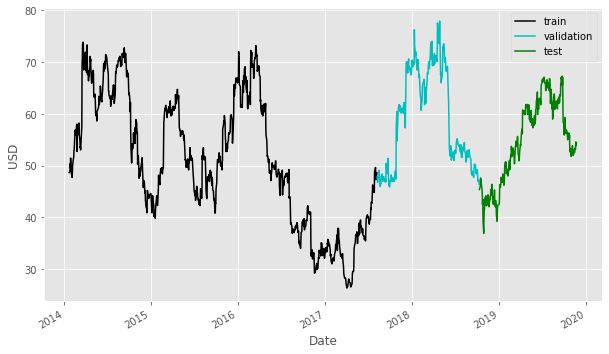

In [10]:
fig,ax=plt.subplots(figsize=(10,6))
for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax = d.plot(x='date', y='adj_close', style=s, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("Date")
ax.set_ylabel("USD")
plt.show();

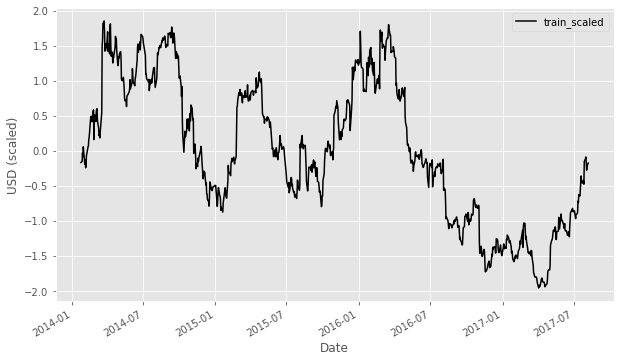

In [11]:
fig,ax=plt.subplots(figsize=(10,6))
ax = train_scaled.plot(x='date', y='adj_close', style='k-', ax=ax)
ax.legend(['train_scaled'])
ax.set_xlabel("Date")
ax.set_ylabel("USD (scaled)")
plt.show();

In [12]:
# Create the model
model = XGBRegressor(objective='reg:squarederror',
                     random_state=seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [13]:
# Do prediction on train set
y_pred_scaled = model.predict(X_train_scaled)
y_pred = y_pred_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

m = forecast_metrics(y_train, y_pred)
print(m)

          RMSE      MAPE    SMAPE  MinMax      Corr
Algo  0.943175  1.429573  1.42797  1.4095  0.997149


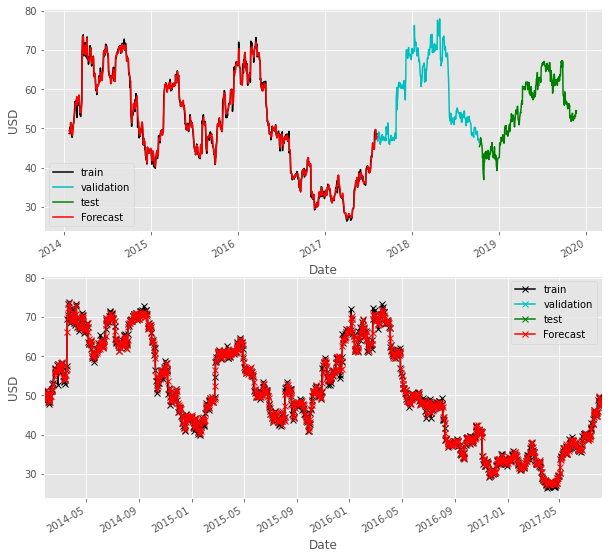

In [14]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
ax[0].plot(train.date, y_pred, 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("USD")

for d,s in zip([train, val, test], ['kx-', 'cx-', 'gx-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
ax[1].plot(train.date, y_pred, 'rx-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([train.date.min(), train.date.max()])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

In [15]:
# Do prediction on val set
y_pred_scaled = model.predict(X_val_scaled)
val['forecast_scaled'] = y_pred_scaled
val['forecast'] = val['forecast_scaled'] * val['adj_close_std'] + val['adj_close_mean']

m = forecast_metrics(y_val, val['forecast'])
print(m)

          RMSE      MAPE     SMAPE    MinMax      Corr
Algo  1.780295  1.904374  1.909073  1.867721  0.982224


In [16]:
rmse_dryrun, mape_dryrun = m.RMSE[0], m.MAPE[0]

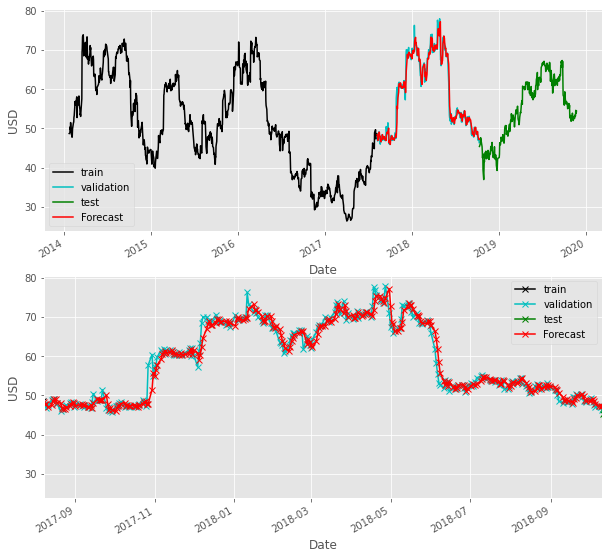

In [17]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
ax[0].plot(val.date, val['forecast'], 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("USD")

for d,s in zip([train, val, test], ['kx-', 'cx-', 'gx-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
ax[1].plot(val.date, val['forecast'], 'rx-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([val.date.min(), val.date.max()])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

In [18]:
# View a list of the features and their importance scores
imp = list(zip(X_train, model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:][::-1]

[('adj_close_lag_2', 0.4767376),
 ('adj_close_lag_1', 0.3388198),
 ('adj_close_lag_3', 0.078976005),
 ('adj_close_lag_4', 0.009895389),
 ('adj_close_lag_15', 0.009427827),
 ('range_oc_lag_1', 0.003534747),
 ('volume_lag_15', 0.0031092553),
 ('range_hl_lag_6', 0.0027712942),
 ('range_oc_lag_15', 0.0025726864),
 ('range_oc_lag_3', 0.0024336164)]

### Tuning N_opt

This will affect the scaling

        RMSE      MAPE     SMAPE    MinMax      Corr
2   1.725213  1.926828  1.930815  1.891482  0.983642
3   1.621288  1.817681  1.821386  1.786435  0.985494
4   1.619833  1.802730  1.804893  1.770117  0.985510
5   1.663305  1.852164  1.854274  1.817661  0.984650
6   1.648719  1.832384  1.836597  1.800489  0.984839
7   1.673734  1.857365  1.861020  1.824016  0.984315
8   1.672468  1.862703  1.866791  1.829694  0.984303
9   1.690238  1.862574  1.866776  1.829470  0.983928
10  1.710494  1.871691  1.874433  1.836228  0.983522
11  1.724701  1.884162  1.887238  1.848295  0.983273
12  1.742268  1.881907  1.885790  1.846188  0.982941
13  1.754887  1.879581  1.883580  1.843440  0.982692
14  1.817185  1.933478  1.938691  1.895724  0.981452
15  1.780295  1.904374  1.909073  1.867721  0.982224
16  1.812821  1.926241  1.928916  1.886065  0.981593
17  1.805383  1.920651  1.924451  1.881614  0.981775
18  1.806683  1.926150  1.928687  1.885777  0.981758
19  1.817673  1.944763  1.948218  1.904771  0.

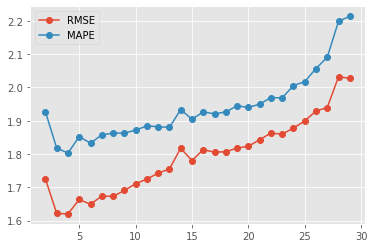

In [19]:
# this is a long cell, but I just copied the feature engineering codes here.
# should be a functional for a production code

metrics = pd.DataFrame()

for N in range(2,30):
    
    cols_to_lag = "volume adj_close range_hl range_oc".split()
    cols_to_scale = ["adj_close"]

    (   scaler, scaler_train_val,
        train, val, train_val, test,
        train_scaled, val_scaled, train_val_scaled, test_scaled,
        X_train, y_train, X_val, y_val, 
        X_train_val, y_train_val, X_test, y_test, 
        X_train_scaled, y_train_scaled, X_val_scaled,
        X_train_val_scaled, y_train_val_scaled, X_test_scaled
    ) = data_preprocessing(data_copy, N, ntrain, nval, cols_to_lag, cols_to_scale)
    
    # Train, predict and eval model
    m, _ = train_pred_eval_model(X_train_scaled, 
                                 y_train_scaled, 
                                 X_val_scaled, 
                                 y_val, 
                                 val['adj_close_mean'],
                                 val['adj_close_std'],
                                 seed=seed,
                                 n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 learning_rate=learning_rate, 
                                 min_child_weight=min_child_weight, 
                                 subsample=subsample, 
                                 colsample_bytree=colsample_bytree, 
                                 colsample_bylevel=colsample_bylevel, 
                                 gamma=gamma,
                                 name=N)
    
    # collect metrics
    metrics = metrics.append(m)

print(metrics)
N_opt = metrics.MAPE.idxmin()
metrics[['RMSE', 'MAPE']].plot(style='o-');

In [24]:
metrics.loc[[metrics.MAPE.idxmin()]]

,RMSE,MAPE,SMAPE,MinMax,Corr
4,1.619833,1.80273,1.804893,1.770117,0.98551


In [25]:
# generate the data again

cols_to_lag = "volume adj_close range_hl range_oc".split()
cols_to_scale = ["adj_close"]

(   scaler, scaler_train_val,
    train, val, train_val, test,
    train_scaled, val_scaled, train_val_scaled, test_scaled,
    X_train, y_train, X_val, y_val, 
    X_train_val, y_train_val, X_test, y_test, 
    X_train_scaled, y_train_scaled, X_val_scaled,
    X_train_val_scaled, y_train_val_scaled, X_test_scaled
) = data_preprocessing(data_copy, N_opt, ntrain, nval, cols_to_lag, cols_to_scale)

### Tuning xgboost parameters

In [26]:
param_label = 'n_estimators'
param_list = [10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['adj_close_mean'],
                                     val['adj_close_std'],
                                     seed=seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma,
                                     name=(param, param2))
    
        # collect metrics
        metrics = metrics.append(m)

print(metrics)
n_estimators_opt, max_depth_opt = metrics.MAPE.idxmin()

              RMSE      MAPE     SMAPE    MinMax      Corr
(10, 2)   1.704857  1.903129  1.899241  1.860947  0.984121
(10, 3)   1.707353  1.906300  1.901778  1.863415  0.984097
(10, 4)   1.710995  1.910545  1.906201  1.867667  0.984011
(10, 5)   1.713398  1.916757  1.912571  1.873982  0.983954
(10, 6)   1.716985  1.919675  1.915284  1.876560  0.983896
...            ...       ...       ...       ...       ...
(500, 5)  1.622321  1.818015  1.820752  1.785953  0.985437
(500, 6)  1.620476  1.817506  1.820534  1.785793  0.985472
(500, 7)  1.624593  1.821861  1.824703  1.789821  0.985401
(500, 8)  1.622055  1.821013  1.823491  1.788765  0.985447
(500, 9)  1.619453  1.820020  1.822864  1.788229  0.985498

[104 rows x 5 columns]


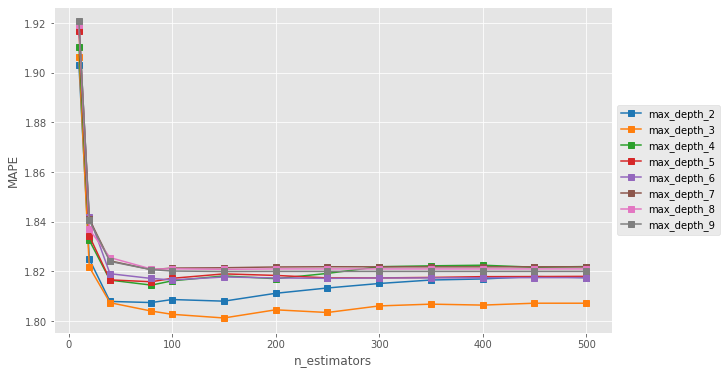

,RMSE,MAPE,SMAPE,MinMax,Corr,n_estimators,max_depth
"(150, 3)",1.618884,1.801254,1.803306,1.768567,0.985521,150,3


In [27]:
plot_two_params_tuning(metrics, param_label, param2_label)
metrics.loc[[metrics.MAPE.idxmin()]]

In [30]:
param_label = 'learning_rate'
param_list = [0.1]  # fixed at first

param2_label = 'min_child_weight'
param2_list = range(1, 31, 1)

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['adj_close_mean'],
                                     val['adj_close_std'],
                                     seed=seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma,
                                     name=param2)
    
        # collect metrics
        metrics = metrics.append(m)

print(metrics)

learning_rate_opt = 0.1
min_child_weight_opt = metrics.MAPE.idxmin()
metrics.loc[[metrics.MAPE.idxmin()]]

        RMSE      MAPE     SMAPE    MinMax      Corr
1   1.618884  1.801254  1.803306  1.768567  0.985521
2   1.623810  1.807122  1.809346  1.774429  0.985437
3   1.621877  1.804137  1.806156  1.771309  0.985476
4   1.621735  1.802722  1.804729  1.769876  0.985476
5   1.624294  1.805887  1.807706  1.772738  0.985431
6   1.620693  1.804622  1.807122  1.772315  0.985484
7   1.617369  1.802082  1.805096  1.770422  0.985540
8   1.627086  1.811052  1.813537  1.778482  0.985367
9   1.624109  1.807002  1.809449  1.774509  0.985424
10  1.624308  1.808711  1.811397  1.776444  0.985415
11  1.618102  1.801236  1.803776  1.769065  0.985530
12  1.618560  1.799399  1.801884  1.767151  0.985527
13  1.621025  1.802997  1.805569  1.770718  0.985482
14  1.618609  1.800534  1.802472  1.767738  0.985531
15  1.619128  1.802880  1.805285  1.770491  0.985514
16  1.617647  1.800581  1.802965  1.768254  0.985545
17  1.616322  1.801477  1.804485  1.769834  0.985556
18  1.618128  1.803558  1.806593  1.771868  0.

,RMSE,MAPE,SMAPE,MinMax,Corr
20,1.612982,1.798807,1.802125,1.767621,0.985614


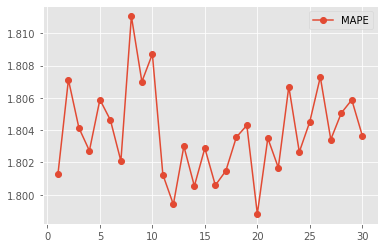

In [31]:
metrics.plot(y=['MAPE'], style='o-');

In [32]:
# Tuning XGBoost - subsample(default=1) and gamma(default=0)

param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['adj_close_mean'],
                                     val['adj_close_std'],
                                     seed=seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2,
                                     name=(param, param2))
    
        # collect metrics
        metrics = metrics.append(m)

print(metrics)

subsample_opt, gamma_opt = metrics.MAPE.idxmin()
metrics.loc[[metrics.MAPE.idxmin()]]

                RMSE      MAPE     SMAPE    MinMax      Corr
(0.1, 0.1)  1.700888  1.902400  1.905827  1.867456  0.983949
(0.1, 0.2)  1.713350  1.915113  1.918314  1.879431  0.983714
(0.1, 0.3)  1.721467  1.921653  1.924305  1.885050  0.983561
(0.1, 0.4)  1.719286  1.919848  1.922387  1.883222  0.983606
(0.1, 0.5)  1.728703  1.930810  1.933847  1.894287  0.983424
...              ...       ...       ...       ...       ...
(1, 0.6)    1.641723  1.828551  1.831918  1.796291  0.985085
(1, 0.7)    1.640345  1.827651  1.831113  1.795542  0.985109
(1, 0.8)    1.640436  1.827564  1.831050  1.795483  0.985108
(1, 0.9)    1.639681  1.827275  1.830719  1.795180  0.985121
(1, 1)      1.639932  1.827515  1.830989  1.795440  0.985117

[100 rows x 5 columns]


,RMSE,MAPE,SMAPE,MinMax,Corr
"(0.8, 0.1)",1.615524,1.800526,1.803327,1.768726,0.985576


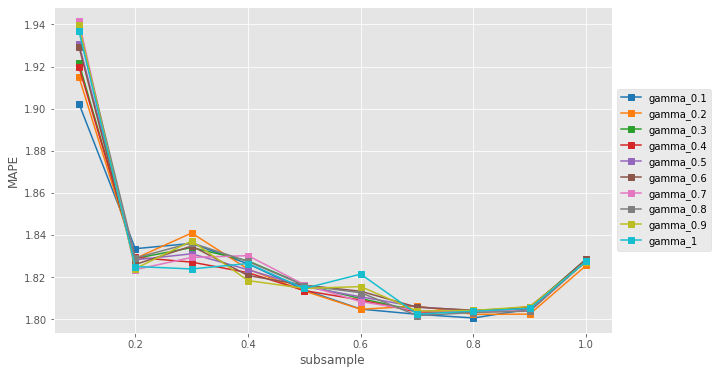

In [33]:
plot_two_params_tuning(metrics, param_label, param2_label)

In [34]:
### Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)

param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['adj_close_mean'],
                                     val['adj_close_std'],
                                     seed=seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt,
                                     name=(param, param2))
    
        # collect metrics
        metrics = metrics.append(m)

print(metrics)

colsample_bytree_opt, colsample_bylevel_opt = metrics.MAPE.idxmin()
metrics.loc[[metrics.MAPE.idxmin()]]

                RMSE      MAPE     SMAPE    MinMax      Corr
(0.5, 0.5)  1.842509  2.058124  2.063421  2.018899  0.981141
(0.5, 0.6)  1.842509  2.058124  2.063421  2.018899  0.981141
(0.5, 0.7)  1.828870  2.024240  2.028648  1.984835  0.981421
(0.5, 0.8)  1.777953  1.984531  1.989271  1.947672  0.982443
(0.5, 0.9)  1.786027  1.987598  1.991701  1.949941  0.982281
(0.5, 1)    1.670893  1.870154  1.874073  1.837210  0.984517
(0.6, 0.5)  1.913389  2.128135  2.132240  2.084166  0.979645
(0.6, 0.6)  1.828736  2.034035  2.038265  1.994347  0.981426
(0.6, 0.7)  1.788527  1.988572  1.992778  1.950701  0.982248
(0.6, 0.8)  1.730200  1.928736  1.932510  1.893096  0.983393
(0.6, 0.9)  1.703084  1.904770  1.908530  1.870214  0.983910
(0.6, 1)    1.667062  1.866392  1.869747  1.833043  0.984592
(0.7, 0.5)  1.922886  2.138069  2.140697  2.092234  0.979457
(0.7, 0.6)  1.842574  2.050072  2.054661  2.009951  0.981142
(0.7, 0.7)  1.764289  1.967051  1.970560  1.929606  0.982723
(0.7, 0.8)  1.724562  1.

,RMSE,MAPE,SMAPE,MinMax,Corr
"(0.9, 1)",1.606762,1.791719,1.794896,1.76064,0.985731


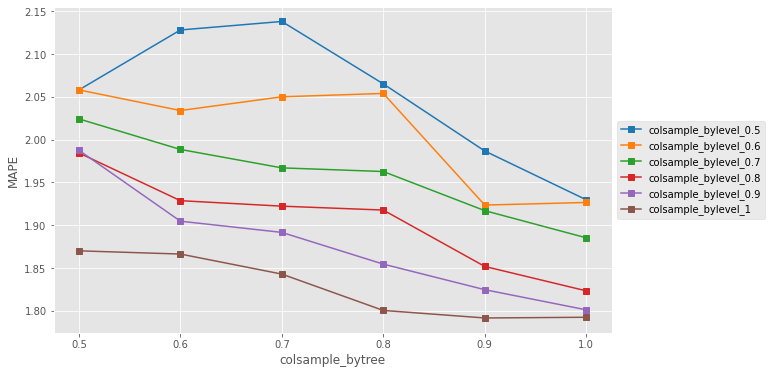

In [35]:
plot_two_params_tuning(metrics, param_label, param2_label)

In [36]:
### Tuning XGBoost - final learning_rate and n_estimators, they should be optimized together

param_label = 'learning_rate'
param_list = [0.001, 0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

param2_label = 'n_estimators'
param2_list = [10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['adj_close_mean'],
                                     val['adj_close_std'],
                                     seed=seed,
                                     n_estimators=param2, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=colsample_bytree_opt, 
                                     colsample_bylevel=colsample_bylevel_opt, 
                                     gamma=gamma_opt,
                                     name=(param, param2))
    
        # collect metrics
        metrics = metrics.append(m)

print(metrics)

learning_rate_opt, n_estimators_opt = metrics.MAPE.idxmin()
metrics.loc[[metrics.MAPE.idxmin()]]

                  RMSE      MAPE     SMAPE    MinMax      Corr
(0.001, 10)   2.275855  2.537616  2.509687  2.443823  0.973120
(0.001, 20)   2.266481  2.527188  2.499720  2.434363  0.973318
(0.001, 40)   2.248855  2.507501  2.480931  2.416519  0.973686
(0.001, 80)   2.209822  2.463439  2.438620  2.376290  0.974510
(0.001, 100)  2.191747  2.442929  2.418927  2.357550  0.974887
...                ...       ...       ...       ...       ...
(0.3, 300)    1.605828  1.796043  1.799490  1.765220  0.985743
(0.3, 350)    1.605378  1.796173  1.799582  1.765345  0.985752
(0.3, 400)    1.605950  1.797078  1.800414  1.766159  0.985743
(0.3, 450)    1.604377  1.794940  1.798065  1.763901  0.985771
(0.3, 500)    1.603374  1.795086  1.798051  1.763940  0.985789

[117 rows x 5 columns]


,RMSE,MAPE,SMAPE,MinMax,Corr
"(0.15, 450)",1.604554,1.788614,1.791923,1.757772,0.985771


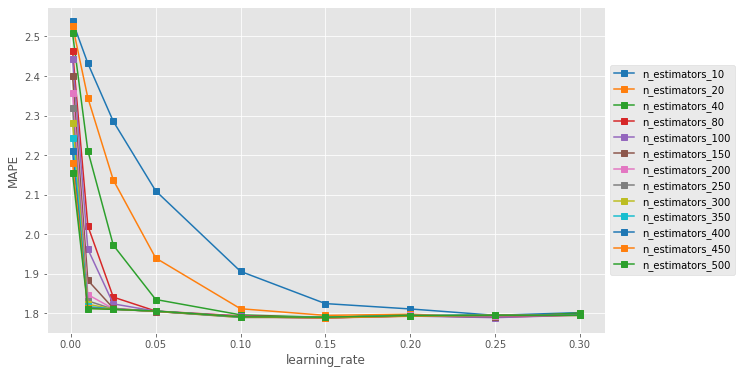

In [37]:
plot_two_params_tuning(metrics, param_label, param2_label)

In [38]:
metrics[(metrics.learning_rate==0.1) | (metrics.learning_rate==0.15)].sort_values(by='MAPE').head(10)

,RMSE,MAPE,SMAPE,MinMax,Corr,learning_rate,n_estimators
"(0.15, 450)",1.604554,1.788614,1.791923,1.757772,0.985771,0.15,450.0
"(0.15, 150)",1.602059,1.788844,1.792589,1.758530,0.985814,0.15,150.0
"(0.15, 100)",1.602316,1.788922,1.792644,1.758576,0.985809,0.15,100.0
"(0.15, 200)",1.602640,1.789008,1.792581,1.758502,0.985804,0.15,200.0
"(0.15, 400)",1.604866,1.789159,1.792486,1.758315,0.985765,0.15,400.0
"(0.1, 250)",1.605161,1.789871,1.793206,1.759008,0.985759,0.10,250.0
"(0.15, 80)",1.603549,1.790077,1.793672,1.759554,0.985788,0.15,80.0
"(0.15, 40)",1.602348,1.790107,1.793668,1.759594,0.985807,0.15,40.0
"(0.15, 350)",1.605051,1.790131,1.793465,1.759286,0.985762,0.15,350.0
"(0.1, 300)",1.605544,1.790139,1.793462,1.759250,0.985753,0.10,300.0


In [39]:
learning_rate_opt, n_estimators_opt = 0.15, 150

### Final model, test set

In [40]:
metrics, y_pred = train_pred_eval_model(X_train_val_scaled, 
                             y_train_val_scaled, 
                             X_test_scaled, 
                             y_test, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt,
                             name='XGBoost')

print(metrics)

             RMSE      MAPE     SMAPE    MinMax      Corr
XGBoost  1.261512  1.756565  1.752936  1.725214  0.986948


### Plotting on test set

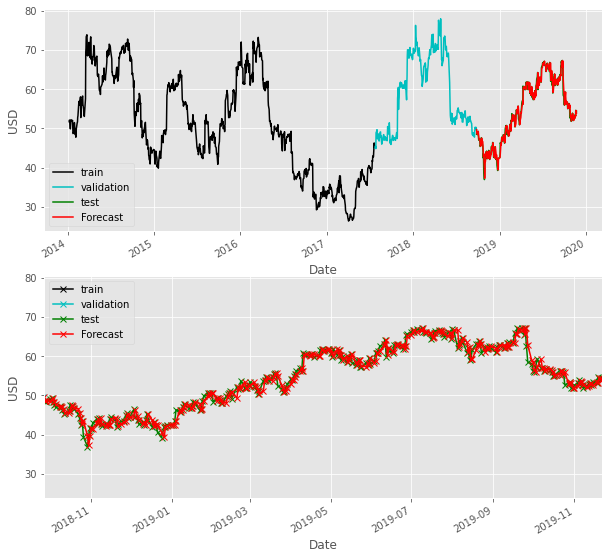

In [41]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
ax[0].plot(test.date, y_pred, 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("USD")

for d,s in zip([train, val, test], ['kx-', 'cx-', 'gx-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
ax[1].plot(test.date, y_pred, 'rx-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([test.date.min(), test.date.max()])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

### Save predictions

In [42]:
test[f'forcast'] = y_pred
test.to_csv("./out/test_xgboost.csv")

In [43]:
print(metrics)

             RMSE      MAPE     SMAPE    MinMax      Corr
XGBoost  1.261512  1.756565  1.752936  1.725214  0.986948
